In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# interactive chart ... makes things slower!
#%matplotlib notebook

<IPython.core.display.Javascript object>

In [3]:
import zipline
from zipline.api import (
    future_symbol,
    set_commission,
    set_slippage,
    schedule_function,
    date_rules,
    time_rules,
    continuous_future,
    order_target,
)
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import pyfolio as pf
import pandas as pd
import numpy as np
from zipline.finance.commission import PerShare, PerTrade, PerContract
from zipline.finance.slippage import (
    VolumeShareSlippage,
    FixedSlippage,
    VolatilityVolumeShare,
)

<IPython.core.display.Javascript object>

In [4]:
"""
Model Settings
"""
starting_portfolio = 10000000
risk_factor = 0.001
vola_window = 60
# short_trend_window = 125
# long_trend_window = 250
short_trend_window = 5
long_trend_window = 10

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Time Return Performance')

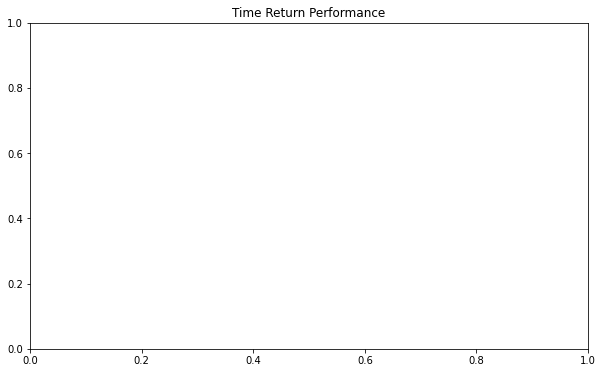

<IPython.core.display.Javascript object>

In [5]:
"""
Prepare for dynamic chart
"""
dynamic_results = pd.DataFrame()
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Time Return Performance")

In [6]:
def initialize(context):
    """
    Cost Settings
    """
    context.enable_commission = True
    context.enable_slippage = True

    if context.enable_commission:
        comm_model = PerContract(cost=0.85, exchange_fee=1.5)
    else:
        comm_model = PerTrade(cost=0.0)

    set_commission(us_futures=comm_model)

    if context.enable_slippage:
        slippage_model = VolatilityVolumeShare(volume_limit=0.2)
    else:
        slippage_model = FixedSlippage(spread=0.0)

    set_slippage(us_futures=slippage_model)

    #     currencies = [
    #         "AD",
    #         "BP",
    #         "CD",
    #         "CU",
    #         "DX",
    #         "JY",
    #         "NE",
    #         "SF",
    #     ]
    #     agriculturals = [
    #         "BL",
    #         "BO",
    #         "_C",
    #         "CC",
    #         "CT",
    #         "FC",
    #         "KC",
    #         "LB",
    #         "LC",
    #         "LR",
    #         "LS",
    #         "_O",
    #         "_S",
    #         "SB",
    #         "_W",
    #     ]
    #     nonagriculturals = [
    #         "CL",
    #         "GC",
    #         "HG",
    #         "HO",
    #         "LG",
    #         "NG",
    #         "PA",
    #         "PL",
    #         "RB",
    #         "SI",
    #     ]
    #     equities = [
    #         "ES",
    #         "NK",
    #         "NQ",
    #         "TW",
    #         "VX",
    #         "YM",
    #     ]
    #     rates = [
    #         "ED",
    #         "FV",
    #         "TU",
    #         "TY",
    #         "US",
    #     ]

    #     # Join sector lists into one list
    #     markets = currencies + agriculturals + nonagriculturals + equities + rates
    # since we used random futures data...
    markets = pd.read_csv("/tmp/random_test_data/data/futures_meta/meta.csv")[
        "root_symbol"
    ].tolist()

    #     not sure why but these markets have problems rolling over
    PROBLEMATIC_MARKETS = [
        "CL",
        "DA",
        "KW",
        "LO",
        "LG",
        "MP",
        "MW",
        "NG",
        "TF",
        "YM",
        "_W",
    ]
    markets = [market for market in markets if market not in PROBLEMATIC_MARKETS]
    #     markets = ["AD"]

    # Make a list of all continuations
    context.universe = [
        continuous_future(market, offset=0, roll="volume", adjustment="mul")
        for market in markets
    ]

    # Schedule daily trading
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_close())

    # Schedule daily roll check
    schedule_function(roll_futures, date_rules.every_day(), time_rules.market_close())

    # Schedule monthly chart update
    schedule_function(update_chart, date_rules.month_start(), time_rules.market_close())

<IPython.core.display.Javascript object>

In [7]:
def update_chart(context, data):
    # This function continuously update the graph during the backtest
    today = data.current_session.date()
    dynamic_results.loc[today, "PortfolioValue"] = context.portfolio.portfolio_value

    if ax.lines:  # Update existing line
        ax.lines[0].set_xdata(dynamic_results.index)
        ax.lines[0].set_ydata(dynamic_results.PortfolioValue)
    else:  # Create new line
        ax.semilogy(dynamic_results)

    # Update scales min/max
    ax.set_ylim(
        dynamic_results.PortfolioValue.min(), dynamic_results.PortfolioValue.max()
    )
    ax.set_xlim(dynamic_results.index.min(), dynamic_results.index.max())

    # Redraw the graph
    fig.canvas.draw()

<IPython.core.display.Javascript object>

In [8]:
def roll_futures(context, data):
    today = data.current_session.date()
    open_orders = zipline.api.get_open_orders()
    for held_contract in context.portfolio.positions:
        if held_contract in open_orders:
            continue
        days_to_auto_close = (held_contract.auto_close_date.date() - today).days
        if days_to_auto_close > 10:
            continue

        # Make a continuation
        continuation = continuous_future(
            held_contract.root_symbol, offset=0, roll="volume", adjustment="mul"
        )
        continuation_contract = data.current(continuation, "contract")

        if continuation_contract != held_contract:
            pos_size = context.portfolio.positions[held_contract].amount
            order_target(held_contract, 0)
            order_target(continuation_contract, pos_size)

<IPython.core.display.Javascript object>

In [9]:
def position_size(portfolio_value, std, pv, avg_volume):
    target_variation = portfolio_value * risk_factor
    contract_variation = std * pv
    contracts = target_variation / contract_variation
    return int(np.nan_to_num(contracts))

<IPython.core.display.Javascript object>

In [10]:
def rebalance(context, data):
    # Get the history
    print(f"getting history for {data}")
    hist = data.history(
        context.universe,
        fields=["close", "volume"],
        frequency="1d",
        bar_count=long_trend_window,
    )

    print(hist)

    # Make a dictionary of open positions
    open_pos = {pos.root_symbol: pos for pos in context.portfolio.positions}

    # Loop all markets
    for continuation in context.universe:
        # Slice off history for this market
        h = hist.xs(continuation, 2)
        root = continuation.root_symbol

        # Calculate volatility
        std = h.close.diff()[-vola_window:].std()

        if root in open_pos:  # Position is already open
            p = context.portfolio.positions[open_pos[root]]
            if p.amount > 0:  # Long position
                if h.close[-1] < h.close[-long_trend_window]:
                    # Lost slow trend, close position
                    order_target(open_pos[root], 0)
                elif h.close[-1] < h.close[-short_trend_window]:
                    # Lost fast trend, close position
                    order_target(open_pos[root], 0)
            else:  # Short position
                if h.close[-1] > h.close[-long_trend_window]:
                    # Lost slow trend, close position
                    order_target(open_pos[root], 0)
                elif h.close[-1] > h.close[-short_trend_window]:
                    # Lost fast trend, close position
                    order_target(open_pos[root], 0)

        else:  # No position open yet.
            if (h.close[-1] > h.close[-long_trend_window]) and (
                h.close[-1] > h.close[-short_trend_window]
            ):
                # Buy new position
                contract = data.current(continuation, "contract")
                contracts_to_trade = position_size(
                    context.portfolio.portfolio_value,
                    std,
                    contract.price_multiplier,
                    h["volume"][-20:].mean(),
                )

                order_target(contract, contracts_to_trade)
            elif (h.close[-1] < h.close[-long_trend_window]) and (
                h.close[-1] < h.close[-short_trend_window]
            ):
                # New short position
                contract = data.current(continuation, "contract")
                contracts_to_trade = position_size(
                    context.portfolio.portfolio_value,
                    std,
                    contract.price_multiplier,
                    h["volume"][-20:].mean(),
                )

                order_target(contract, contracts_to_trade * -1)

<IPython.core.display.Javascript object>

In [11]:
start = pd.Timestamp("2018-01-01 08:15:12", tz="utc")
end = pd.Timestamp("2018-12-31 08:15:12", tz="utc")

<IPython.core.display.Javascript object>

In [12]:
%%time
perf = zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=starting_portfolio,
    data_frequency="daily",
    bundle="random_futures",
)

<string>:12: UserWarning: Overwriting bundle with name 'random_futures'
<string>:18: UserWarning: Overwriting bundle with name 'random_futures'


getting history for <zipline._protocol.BarData object at 0x7f19dda209d8>
<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 10 (major_axis) x 42 (minor_axis)
Items axis: close to volume
Major_axis axis: 2017-12-18 00:00:00+00:00 to 2018-01-02 00:00:00+00:00
Minor_axis axis: ContinuousFuture(90428234331652096 [AD, 0, volume, mul]) to ContinuousFuture(96361199075131392 [VX, 0, volume, mul])


/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Attempting to set identical bottom == top == 10000000.0 results in singular transformations; automatically expanding.
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Attempting to set identical left == right == 17533.0 results in singular transformations; automatically expanding.
  app.launch_new_instance()


getting history for <zipline._protocol.BarData object at 0x7f19dda209d8>
<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 10 (major_axis) x 42 (minor_axis)
Items axis: close to volume
Major_axis axis: 2018-01-19 00:00:00+00:00 to 2018-02-01 00:00:00+00:00
Minor_axis axis: ContinuousFuture(90428234331652096 [AD, 0, volume, mul]) to ContinuousFuture(96361199075131392 [VX, 0, volume, mul])
getting history for <zipline._protocol.BarData object at 0x7f19dda209d8>
<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 10 (major_axis) x 42 (minor_axis)
Items axis: close to volume
Major_axis axis: 2018-02-15 00:00:00+00:00 to 2018-03-01 00:00:00+00:00
Minor_axis axis: ContinuousFuture(90428234331652096 [AD, 0, volume, mul]) to ContinuousFuture(96361199075131392 [VX, 0, volume, mul])
getting history for <zipline._protocol.BarData object at 0x7f19dda209d8>
<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 10 (major_axis) x 42 (minor_axis)
Items axis: close to volume
Major_axi

<IPython.core.display.Javascript object>

Start date,2018-01-02
End date,2018-12-31
Total months,11
,Backtest
Annual return,-67.8%
Cumulative returns,-67.6%
Annual volatility,9.0%
Sharpe ratio,-12.58
Calmar ratio,-1.00
Stability,0.93
Max drawdown,-67.8%


/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,67.81,2018-01-18,2018-12-31,NaT,NaN
1,0.52,2018-01-02,2018-01-04,2018-01-11,8
2,0.11,2018-01-16,2018-01-17,2018-01-18,3
3,0.00,2018-01-02,2018-01-02,2018-01-02,1
4,0.00,2018-01-02,2018-01-02,2018-01-02,1


/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute 

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_compat.py:57: MatplotlibDeprecationWarning: 
The compare_versions function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  return matplotlib.compare_versions('2.0.0', matplotlib.__version__)
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
Th

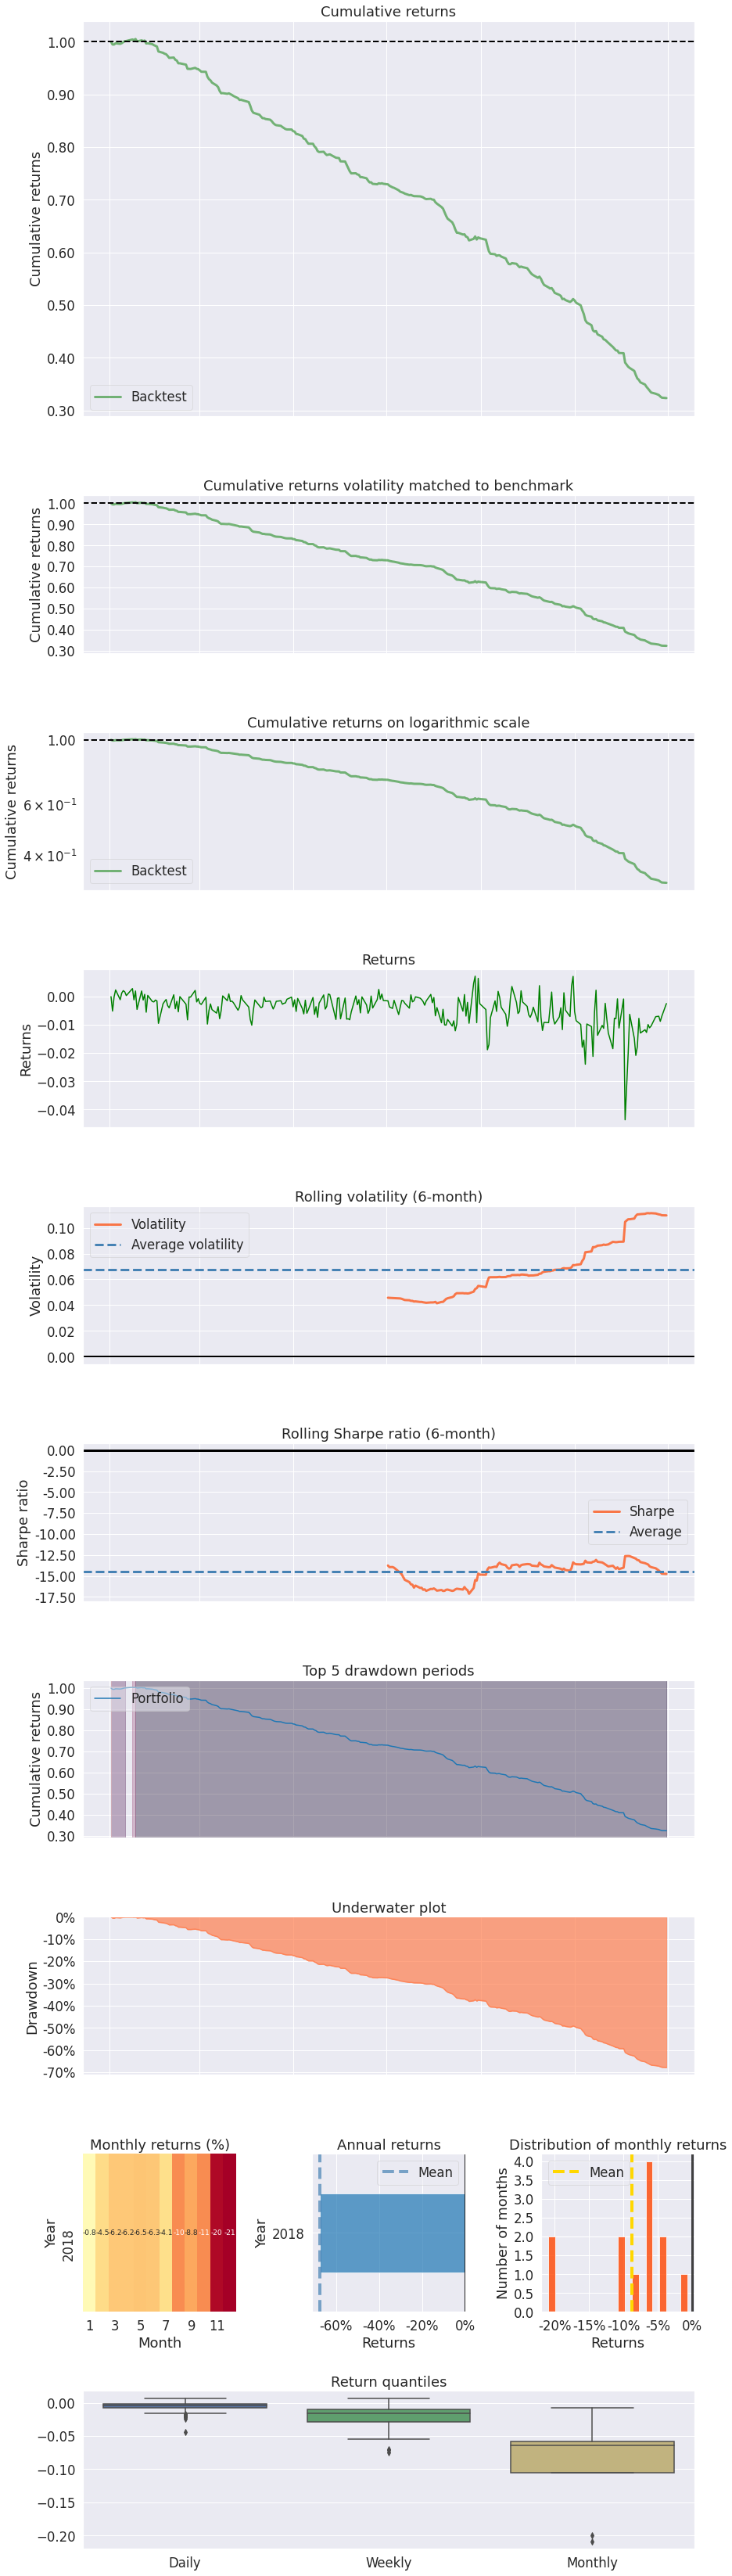

<IPython.core.display.Javascript object>

In [13]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
pf.create_returns_tear_sheet(returns, benchmark_rets=None)